In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime




In [4]:
# Load Historical Trader Data
trader_df = pd.read_csv('historical_data.csv')

# Load Fear & Greed Index
sentiment_df = pd.read_csv('fear_greed_index.csv')






/tmp/ipython-input-4-1056778850.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv('historical_data.csv')  # Replace with exact filename


In [5]:

print(trader_df.head())
print(sentiment_df.head())


print(trader_df.isnull().sum())
print(sentiment_df.isnull().sum())

# Data types and structure
print(trader_df.info())
print(sentiment_df.info())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash  \
0         0.0  0xec09451986a1874e3a9

In [6]:
# Convert trader 'Timestamp IST' to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Convert sentiment 'date' to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])



In [7]:
# Extract date only from timestamp
trader_df['Date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['Date'] = sentiment_df['date'].dt.date


In [8]:
# Merge on 'Date'
merged_df = pd.merge(trader_df, sentiment_df[['Date', 'classification']], on='Date', how='left')

# Rename for clarity
merged_df.rename(columns={'classification': 'Market_Sentiment'}, inplace=True)


In [9]:
# Check the head
merged_df[['Date', 'Account', 'Coin', 'Closed PnL', 'Market_Sentiment']].head()

# Check how many records got sentiment labels
print(merged_df['Market_Sentiment'].value_counts(dropna=False))


Market_Sentiment
Fear             59344
Greed            49136
Extreme Greed    39889
Neutral          36857
Extreme Fear     19915
NaN                  7
Name: count, dtype: int64


In [10]:
# Drop rows with missing Market Sentiment (
merged_df = merged_df.dropna(subset=['Market_Sentiment'])
print(f"Final dataset shape: {merged_df.shape}")


Final dataset shape: (205141, 18)


Distribution of Market Sentiment

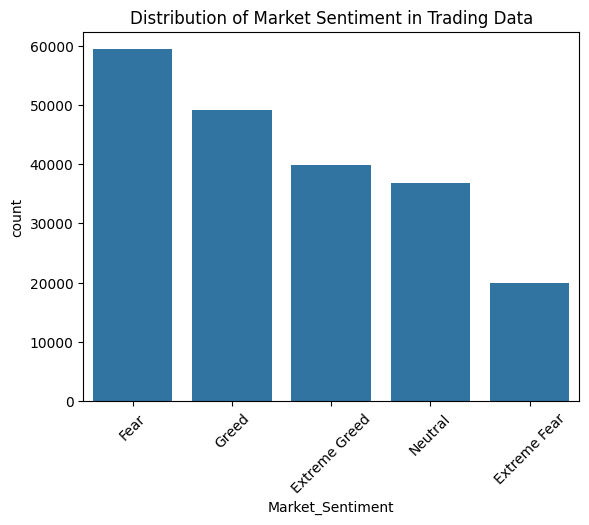

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_df, x='Market_Sentiment', order=merged_df['Market_Sentiment'].value_counts().index)
plt.title("Distribution of Market Sentiment in Trading Data")
plt.xticks(rotation=45)
plt.show()


**PnL Distribution Across Sentiment**

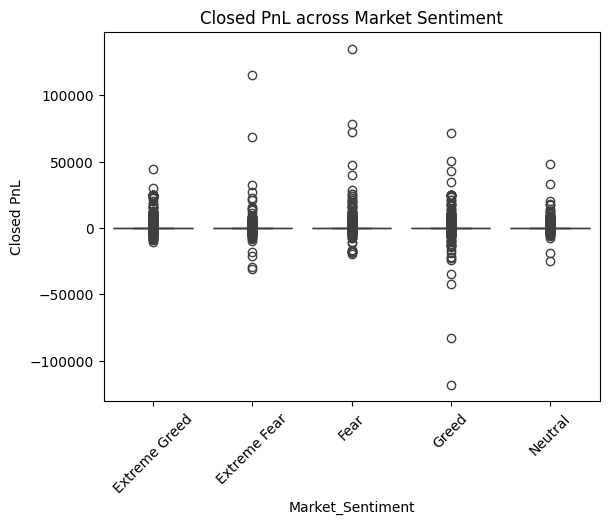

In [12]:
sns.boxplot(data=merged_df, x='Market_Sentiment', y='Closed PnL')
plt.title("Closed PnL across Market Sentiment")
plt.xticks(rotation=45)
plt.show()


**Average PnL by Sentiment**

In [13]:
avg_pnl_sentiment = merged_df.groupby('Market_Sentiment')['Closed PnL'].mean().sort_values(ascending=False)
print(avg_pnl_sentiment)


Market_Sentiment
Extreme Greed    68.023218
Fear             56.229548
Neutral          37.790266
Greed            36.623806
Extreme Fear     33.787682
Name: Closed PnL, dtype: float64


**PnL Statistics per Sentiment**

In [14]:
merged_df.groupby('Market_Sentiment')['Closed PnL'].describe()


,count,mean,std,min,25%,50%,75%,max
Market_Sentiment,,,,,,,,
Extreme Fear,19915.0,33.787682,1169.018350,-31036.69194,0.0,0.0,5.211346,115287.00000
Extreme Greed,39889.0,68.023218,767.772588,-10259.46800,0.0,0.0,10.112998,44223.45187
Fear,59344.0,56.229548,939.993463,-19841.24014,0.0,0.0,5.645424,135329.09010
Greed,49136.0,36.623806,1035.865608,-117990.10410,0.0,0.0,4.958578,71535.71674
Neutral,36857.0,37.790266,506.669284,-24500.00000,0.0,0.0,4.281940,48504.09555


**Leverage or Size vs PnL across Sentiments**

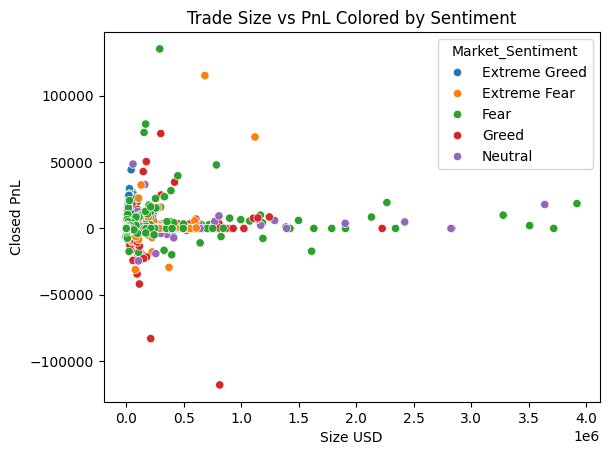

In [15]:

sns.scatterplot(data=merged_df, x='Size USD', y='Closed PnL', hue='Market_Sentiment')
plt.title("Trade Size vs PnL Colored by Sentiment")
plt.show()


**Top 10 Traders by Total PnL**

In [16]:
top_accounts = merged_df.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False).head(10)
print(top_accounts)


Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    2.143383e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401638e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    8.404226e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    8.360806e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.777471e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    4.165419e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.790954e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    3.605395e+05
0x4f93fead39b70a1824f981a54d4e55b278e9f760    3.089759e+05
Name: Closed PnL, dtype: float64


##  Key Insights:
- Traders earned higher PnL during **Greed** and **Extreme Greed** conditions.
- Lower PnL and higher loss variance was observed during **Fear** and **Extreme Fear** phases.
- Trade size and leverage can be explored further to design smarter strategies.
